# Inference on test data (2019-2020)

In [1]:
import os
import sys
import toml
import numpy as np
import xarray as xr
from tqdm import tqdm
from typing import Any
from itertools import islice


import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.markers as markers
from mpl_toolkits.axes_grid1 import make_axes_locatable    

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter)

_pth = "../"
if _pth not in sys.path:
	sys.path.append(_pth)

from Fires._datasets.torch_dataset import FireDataset
from Fires._models.unetpp import UnetPlusPlus
from Fires._scalers.standard import StandardScaler


Path to config: /Users/emanueledonno/VSCode/CMCC/ML4Fires/config
/Users/emanueledonno/VSCode/CMCC/ML4Fires/digital_twin_notebooks


/Users/emanueledonno/opt/anaconda3/envs/cmcc-torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# # memory usage
# data_mem = lambda data: round(data.size / pow(1024, 2), 2) if type(data) == np.ndarray else round(data.nbytes / pow(1024, 2), 2)
# print(f"Memory usage (Dataset): {data_mem(test_data)} MB")
# print(f"Memory usage (DataArray): {data_mem(test_data.to_array())} MB")
# print(f"Memory usage (numpy): {data_mem(test_data.to_array().values)} MB")

In [3]:
from Fires._macros.macros import 

# define path to complete dataset
DS_PATH = os.path.join(os.path.dirname(os.getcwd()), "data", "seasfire_100km.zarr")

# open the dataset and choose a subset
dataset = xr.open_zarr(DS_PATH).load()
test_data = dataset.sel(time=slice('2019', '2020'))

# define drivers and targets
__features = list(test_data.data_vars)
drivers, targets = __features[:-1], [__features[-1]]

# define max hectares value 
MAX_HECTARES = pow((111), 2) * 100

# load the land sea mask and substitute zeros with NaN values
lsm = dataset.lsm.values
lsm[lsm == 0] = np.nan
MAX_HECT_LSM_MAP = lsm * MAX_HECTARES

# define latitudes and longitudes
lats = dataset.latitude.values
lons = dataset.longitude.values
print(f"Latitude count: {len(lats)} \t Longitude count: {len(lons)}")

Latitude count: 180 	 Longitude count: 360


In [4]:
# # memory usage
# test_data_2 = dataset.sel(time=slice('2019-01-01', '2019-01-01'))
# print(test_data_2.to_array().values.shape)

# data_mem = lambda data: round(data.size / pow(1024, 2), 2) if type(data) == np.ndarray else round(data.nbytes / pow(1024, 2), 2)
# print(f"Memory usage (Dataset): {data_mem(test_data_2)} MB")
# print(f"Memory usage (DataArray): {data_mem(test_data_2.to_array())} MB")
# print(f"Memory usage (numpy): {data_mem(test_data_2.to_array().values)} MB")

# np.save("../data/test_data_2", test_data_2.to_array().values)

In [5]:
# path to the experiments folder with last model
EXP_PATH = os.path.join(os.path.dirname(os.getcwd()), 'experiments', '20240717_256')
print(f"Path to the experiment folder: {EXP_PATH}")

Path to the experiment folder: /Users/emanueledonno/VSCode/CMCC/ML4Fires/experiments/20240717_256


In [6]:
# define model
model = UnetPlusPlus(
	input_shape = (180, 360, 8),
	depth = 2,
	activation = torch.nn.modules.activation.Sigmoid(),
	base_filter_dim = 256
)
# define model loss
model.loss = torch.nn.modules.loss.BCELoss()
# deifne model metrics
model.metrics = []
# define path to last model
path_to_model = os.path.join(EXP_PATH, 'last_model.pt')
# load model from path
lm_state = torch.load(path_to_model, map_location=torch.device('cpu'))['model']
# load weights
model.load_state_dict(lm_state)
# evaluate model
model.eval()

UnetPlusPlus(
  (activation): Sigmoid()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode='bilinear')
  (conv0_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(8, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2_0): VGGB

In [7]:
# define trianing dataset
ds_trn = dataset.sel(time=slice('2001', '2016'))
# compute mean along time, latitude and longitude axes
mean_ds = ds_trn.mean(dim=['time','latitude', 'longitude'], skipna=True)
# compute standard deviation along time, latitude and longitude axes
stdv_ds = ds_trn.std(dim=['time','latitude', 'longitude'], skipna=True)
# define scaler
x_scaler = StandardScaler(mean_ds=mean_ds, stdv_ds=stdv_ds, features=drivers)

In [8]:
# define torch dataset args
ds_args = dict(src=DS_PATH, drivers=drivers, targets=targets, years=list(range(2019, 2021)), scalers=[x_scaler, None])
# define torch dataset for wildfires
tst_torch_ds = FireDataset(**ds_args)

# define torch data loader
test_loader = torch.utils.data.DataLoader(
	tst_torch_ds,
	batch_size=1,
	shuffle=True,
	drop_last=True
)

In [9]:
# perform predictions
with torch.no_grad(): preds = [model(data) for i, (data, _) in enumerate(tqdm(test_loader))]

# define predictions array as vertical stack of predictions list
preds_array = np.vstack(preds)

100%|██████████| 92/92 [10:02<00:00,  6.55s/it]


In [10]:
preds_mean = np.nanmean(preds_array, axis=0)
preds_mean[0].shape

(180, 360)

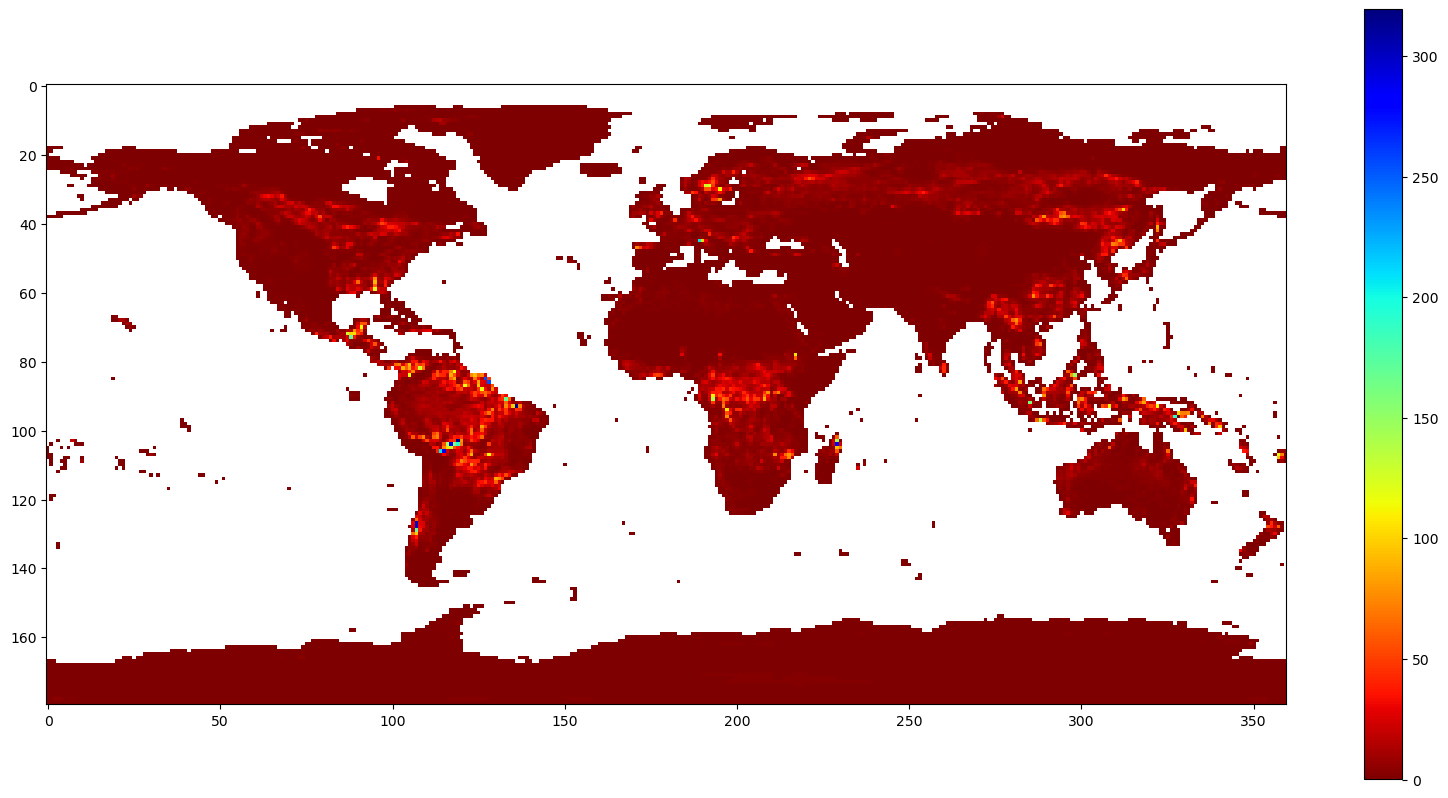

In [11]:

data = preds_mean[0]*MAX_HECT_LSM_MAP
plt.figure(figsize=(20,10))
plt.imshow(data, cmap='jet_r')
plt.colorbar()
plt.show()


In [12]:
def compute_aggregated_data(data, other_data=None, operation="mean") -> tuple[np.ndarray, np.ndarray, np.ndarray]:
	""" Compute the mean or difference between data, and aggregate along latitudes and longitudes

	Args:
		data : numpy.ndarray
		 	Input data, can be unscaled or already scaled and masked depending on the operation to be performed
		other_data : numpy.ndarray
		 	Optional input data for calculating the difference, also assumed to be scaled and masked
		operation : str
			Operation to perform ("mean" for mean, "diff" for difference)

	Returns:
		A tuple containing:
			- Scaled and masked data
			- Mean along latitudes
			- Mean along longitudes
	"""

	if operation == "diff":
		if other_data is None:
			raise ValueError("other_data must be provided when operation is 'diff'")
		data -= other_data  # difference between data that has been masked and rescaled to the original size
	else:
		data *= MAX_HECT_LSM_MAP # mask data with the land sea mask and rescale to original size
	
	descaled_on_lats = np.nanmean(data, axis=1)
	descaled_on_lons = np.nanmean(data, axis=0)

	print(f" {operation.capitalize()} of data: {data.shape}")
	print(f" Max: {round(np.nanmax(data), 2)}")
	print(f" Min: {round(np.nanmin(data), 2)}")
	print(f" Lats: {round(np.nanmax(descaled_on_lats), 2)}")
	print(f" Lons: {round(np.nanmax(descaled_on_lons), 2)}\n")

	return data, descaled_on_lats, descaled_on_lons


In [23]:
# define projection
datacrs = ccrs.PlateCarree()

# define map extent
extent_args=dict(extents = [-180, 180, -90, 90], crs=datacrs)

# define latitudes and longitudes array that must be used for axes
latitudes = np.arange(-60, 90, 30)
longitudes = np.arange(-160, 180, 80)


def draw_features(ax:Any):
	"""
	This function adds several geographical features to the map using Cartopy features:

    * Political borders: outlines country borders with a solid black line style (':') and a linewidth of 0.5.
    * Oceans: outlines the ocean regions with a solid black line style ('-') and a linewidth of 0.8.
    * Lakes: outlines lakes with a solid black line style ('-') and a linewidth of 0.8.
    * Rivers: outlines rivers with a solid black line style ('-') and a linewidth of 0.8.
    * Coastlines: adds high-resolution coastlines (50 meters) to the map with a higher zorder (3) for better visibility.

    **Note:** 
        * Land is not explicitly added in this function. 
        * Adding a background image using `ax.stock_img()` is not implemented. 

	Parameters
	----------
	ax : Any
		The matplotlib axis object to add the features to.

	Returns
	-------
	ax : Any
		The modified matplotlib axis object.

	
    
	"""
	# political borders
	ax.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.5, edgecolor='k')
	# add ocean
	ax.add_feature(cfeature.OCEAN, linestyle='-',linewidth=0.8, edgecolor='k')
	# add lakes
	ax.add_feature(cfeature.LAKES, linestyle='-',linewidth=0.8, edgecolor='k')
	# add rivers
	ax.add_feature(cfeature.RIVERS, linestyle='-',linewidth=0.8, edgecolor='k')
	# add land
	# ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')
	# add coastlines
	ax.coastlines(resolution='50m', zorder=3)
	
	# add stock image
	# ax.stock_img()

	return ax



def highlight_ba(ax:Any, y:float, x:float, color:str):
	"""
	Plots lines and a circle to highlight a specific point on a map.

	Parameters
	----------
	ax : Any
		The matplotlib axis object where to plot the elements.
	y : float
		The latitude value of the point to highlight.
	x : float
		The longitude value of the point to highlight.
	color : str
		The color to use for the lines and circle.

	Returns
	-------
	ax : Any 
		The modified matplotlib axis object.
	"""
	
	# plot lines corresponding to latitude and longitude value of burned areas
	ax.axhline(y=y, color=color, linewidth=3, zorder=3, linestyle=':')
	ax.text(-181.5, np.round(y, 2), f'{np.round(y, 2)}', color=color, fontweight='bold', size=50, ha='center', va='center', rotation=90)
	
	ax.axvline(x=x, color=color, linewidth=3, zorder=3, linestyle=':')
	ax.text(np.round(x, 2), -90.5, f'{np.round(x, 2)}', color=color, fontweight='bold', size=50, ha='center', va='top')
	
	# plot cicle around the pixel with the value of burned areas
	circle = plt.Circle((x, y), 1, color=color, linewidth=5, fill=False, zorder=3)
	ax.add_patch(circle)
	
	return ax



def set_axis(ax, is_y:bool, latlon_vals, gl):
	"""
	Sets the axis labels, ticks, and formatters for latitude or longitude on a map.

	Parameters
	----------
	ax : Any
		The matplotlib axis object to modify.
	is_y : bool
		True if setting the y-axis, False for x-axis.
	latlon_vals : np.array
		The list of latitude or longitude values for the axis.
	gl : Any
		The gridlines object for the map.

	Returns
	-------
	ax : Any
		The modified axis object.
	"""
	values = latlon_vals
	if is_y:
		lat_formatter = LatitudeFormatter()
		ax.yaxis.set_major_formatter(lat_formatter)
		ax.yaxis.set_major_locator(mticker.FixedLocator(values))
		ax.set_yticklabels(values, fontweight='bold', size=50, rotation=90)
		ax.set_yticks(values)
		gl.xlocator = mticker.FixedLocator(values)
		gl.xlines = False

	else:
		lon_formatter = LongitudeFormatter(zero_direction_label=True)
		ax.xaxis.set_major_formatter(lon_formatter)
		ax.xaxis.set_major_locator(mticker.FixedLocator(values))
		ax.set_xticklabels(values, fontweight='bold', size=50)
		ax.set_xticks(values)
		gl.ylocator = mticker.FixedLocator(values)
		gl.ylines = False

	return ax



def draw_tropics_and_equator(ax):
	"""
	Plots lines representing the Tropic of Cancer, Equator, and Tropic of Capricorn on a map.

	Parameters
	----------
	ax : Any
		The matplotlib axis object where to plot the lines.

	Returns
	-------
	ax : Any: 
		The modified matplotlib axis object.
	"""
	ax.axhline(23.5, linestyle=':', color='blue', linewidth=0.7, label='Tropic of Cancer')
	ax.axhline(0.00, linestyle=':', color='black', linewidth=0.7, label='Equator')
	ax.axhline(-23.5, linestyle=':', color='blue', linewidth=0.7, label='Tropic of Capricorn')
	return ax



def plot_dataset_map(
	avg_target_data:np.array,
	avg_data_on_lats:np.array,
	lowerbound_data:np.array,
	upperbound_data:np.array,
	lats:list,
	lons:list,
	title:str,
	cmap:str) -> None:
	"""
	Generates a comprehensive map visualization of a dataset, highlighting 
	minimum and maximum values alongside their confidence intervals.

	Parameters
	----------
	avg_target_data : np.array
		2D array containing the core data to be visualized as color intensity on the map.
		Missing values (NaN) are handled by setting the color to transparent.

	avg_data_on_lats : np.array
		1D array containing the average of the target data for each latitude value.
		This data is plotted as a line in a secondary subplot.

	lowerbound_data : np.array
		2D array containing the lower bound of the data (e.g., standard deviation or confidence interval) for each latitude and longitude.
		This data is used to shade the area around the average line in the secondary subplot.

	upperbound_data : np.array
		2D array containing the upper bound of the data for each latitude and longitude.
		Similar to `lowerbound_data`, it's used for shading the confidence interval in the secondary subplot.

	lats : list
		List containing the latitude values corresponding to the data.

	lons : list
		List containing the longitude values corresponding to the data.

	title : str
		The title to be displayed at the top of the plot.

	cmap : str
		The name of the colormap to use for visualizing the data on the map.
	
	Returns
	-------
	None
		Saves the figure as a high-resolution PNG image (300 dpi) but does not return anything.
	"""
	# define color
	color = 'darkred' #fc6742 #4296fc #990e0e
	
	# compute maximum along latitudes and longitudes and find index
	maximum_val = np.nanmax(avg_target_data)
	lat_idx_max, lon_idx_max  = np.where(avg_target_data==maximum_val)
	max_val_latitude = lats[lat_idx_max][0]
	max_val_longitude = lons[lon_idx_max][0]
	
	# compute minimum along latitudes and longitudes and find index
	minimum_val = np.nanmin(avg_target_data)
	lat_idx_min, lon_idx_min  = np.where(avg_target_data==minimum_val)
	min_val_latitude = lats[lat_idx_min][0]
	min_val_longitude = lons[lon_idx_min][0]
	
	# define fiure and subplots
	_, ax1 = plt.subplots(figsize=(90, 80), subplot_kw=dict(projection=datacrs), sharey=True)
	
	# set title of the plot
	ax1.set_title(title, fontweight='bold', size=80)
	
	# set x and y labels
	ax1.set_xlabel('Longitude [deg]', fontweight='bold', size=50)
	ax1.set_ylabel('Latitude [deg]', fontweight='bold', size=50)
	
	# set map extent
	ax1.set_extent(**extent_args)
	
	# plot map features such as borders, sea, lakes, rivers and background image
	ax1 = draw_features(ax=ax1)
	
	# plot data on the map
	cmap = plt.get_cmap(cmap)
	cmap.set_under((0, 0, 0, 0))
	h = ax1.pcolormesh(lons, lats, avg_target_data, transform=datacrs, cmap=cmap, zorder=3, alpha=0.5, vmin=0.0, vmax=5500.0)
	
	# highlight pixel where the maximum value ov burned areas has been found and put a circle around it
	ax1 = highlight_ba(ax=ax1, y=max_val_latitude, x=max_val_longitude, color=color)
	
	# highlight pixel where the minimum value ov burned areas has been found and put a circle around it
	ax1 = highlight_ba(ax=ax1, y=min_val_latitude, x=min_val_longitude, color='green')
	
	# add grid lines for latitude and longitude
	gl = ax1.gridlines(crs=datacrs, draw_labels=False, linewidth=1.5, color='gray', alpha=0.5, linestyle='-', zorder=3)
	
	# define longitudes and set x ticks
	ax1 = set_axis(ax=ax1, is_y=False, latlon_vals=longitudes, gl=gl)
	
	# define latitudes and set y ticks
	ax1 = set_axis(ax=ax1, is_y=True, latlon_vals=latitudes, gl=gl)
	
	# define latitudes for tropics and equator
	ax1 = draw_tropics_and_equator(ax=ax1)
	
	# add subplot
	divider = make_axes_locatable(ax1)
	ax2 = divider.append_axes("right", size="10%", pad=0.5, axes_class=plt.Axes)
	
	# plot data
	ax2.plot(avg_data_on_lats, lats, color='red', linewidth=1)
	ax2.plot(upperbound_data, lats, alpha=0.3, color='black', linewidth=0.5)
	ax2.plot(lowerbound_data, lats, alpha=0.3, color='black', linewidth=0.5)
	
	# fill space between lines
	ax2.fill_betweenx(y=lats, x1=avg_data_on_lats, x2=upperbound_data, color='gray', alpha=0.15)
	ax2.fill_betweenx(y=lats, x1=avg_data_on_lats, x2=lowerbound_data, color='gray', alpha=0.15)
	
	# define latitudes for tropics (in degrees) and equator
	ax2 = draw_tropics_and_equator(ax=ax2)
	
	# plot max position
	ax2.axhline(max_val_latitude, color=color, linewidth=3)
	
	# plot min position
	ax2.axhline(min_val_latitude, color='green', linewidth=3)
	
	# set x label	
	ax2.set_xlabel(' Mean ', fontweight='bold', size=50, labelpad=50)
	
	# create list of max values
	ax2_vals = np.around([np.nanmin(lowerbound_data, axis=0), np.nanmax(avg_data_on_lats, axis=0), np.nanmax(upperbound_data, axis=0)], 2)
	
	# plot axes tick lines§
	for tick in ax2_vals:
		ax2.axvline(x=tick, color='blue', alpha=1, linewidth=1, linestyle=':')
		ax2.text(round(tick), -.005, f'{round(tick)}', color='blue', fontweight='bold', size=50, transform=ax2.get_xaxis_transform(), ha='center', va='top')

	ax2.text(0, -.005, '0', color='black', fontweight='bold', size=50, transform=ax2.get_xaxis_transform(), ha='center', va='top') 
	
	ax2.set_xticks([])
	ax2.set_yticks([])
	ax2.set_ylim(bottom=-90, top=90)
	ax2.margins(y=0)
	# ax2.autoscale_view(scaley=True)
		
	# add colorbar plot
	ax_cb = divider.append_axes("right", size="2%", pad=0.3, axes_class=plt.Axes)
	cbar = plt.colorbar(h, ax_cb)
	cbar.ax.tick_params(labelsize=30)
	cbar.ax.set_ylabel('Hectares', color='black', fontweight='bold', size=50, labelpad=50, rotation=270)
	
	plt.tight_layout()
	# plt.savefig(f"./img/fcci {title}.png", dpi=300)
	# plt.clf()

/var/folders/93/xz81whms6d14bwb6_wnmc97h0000gn/T/ipykernel_74906/312001994.py:26: RuntimeWarning: Mean of empty slice
  descaled_on_lats = np.nanmean(data, axis=1)
/var/folders/93/xz81whms6d14bwb6_wnmc97h0000gn/T/ipykernel_74906/312001994.py:26: RuntimeWarning: Mean of empty slice
  descaled_on_lats = np.nanmean(data, axis=1)


 Mean of data: (180, 360)
 Max: 5135.48
 Min: 0.0
 Lats: 968.48
 Lons: 535.86

 Mean of data: (180, 360)
 Max: 13253.32
 Min: 0.0
 Lats: 1873.37
 Lons: 1045.07



/var/folders/93/xz81whms6d14bwb6_wnmc97h0000gn/T/ipykernel_74906/312001994.py:26: RuntimeWarning: Mean of empty slice
  descaled_on_lats = np.nanmean(data, axis=1)


 Mean of data: (180, 360)
 Max: 319.32000732421875
 Min: 0.0
 Lats: 18.690000534057617
 Lons: 14.449999809265137

 Mean of data: (180, 360)
 Max: 626.510009765625
 Min: 0.0
 Lats: 36.08000183105469
 Lons: 24.489999771118164



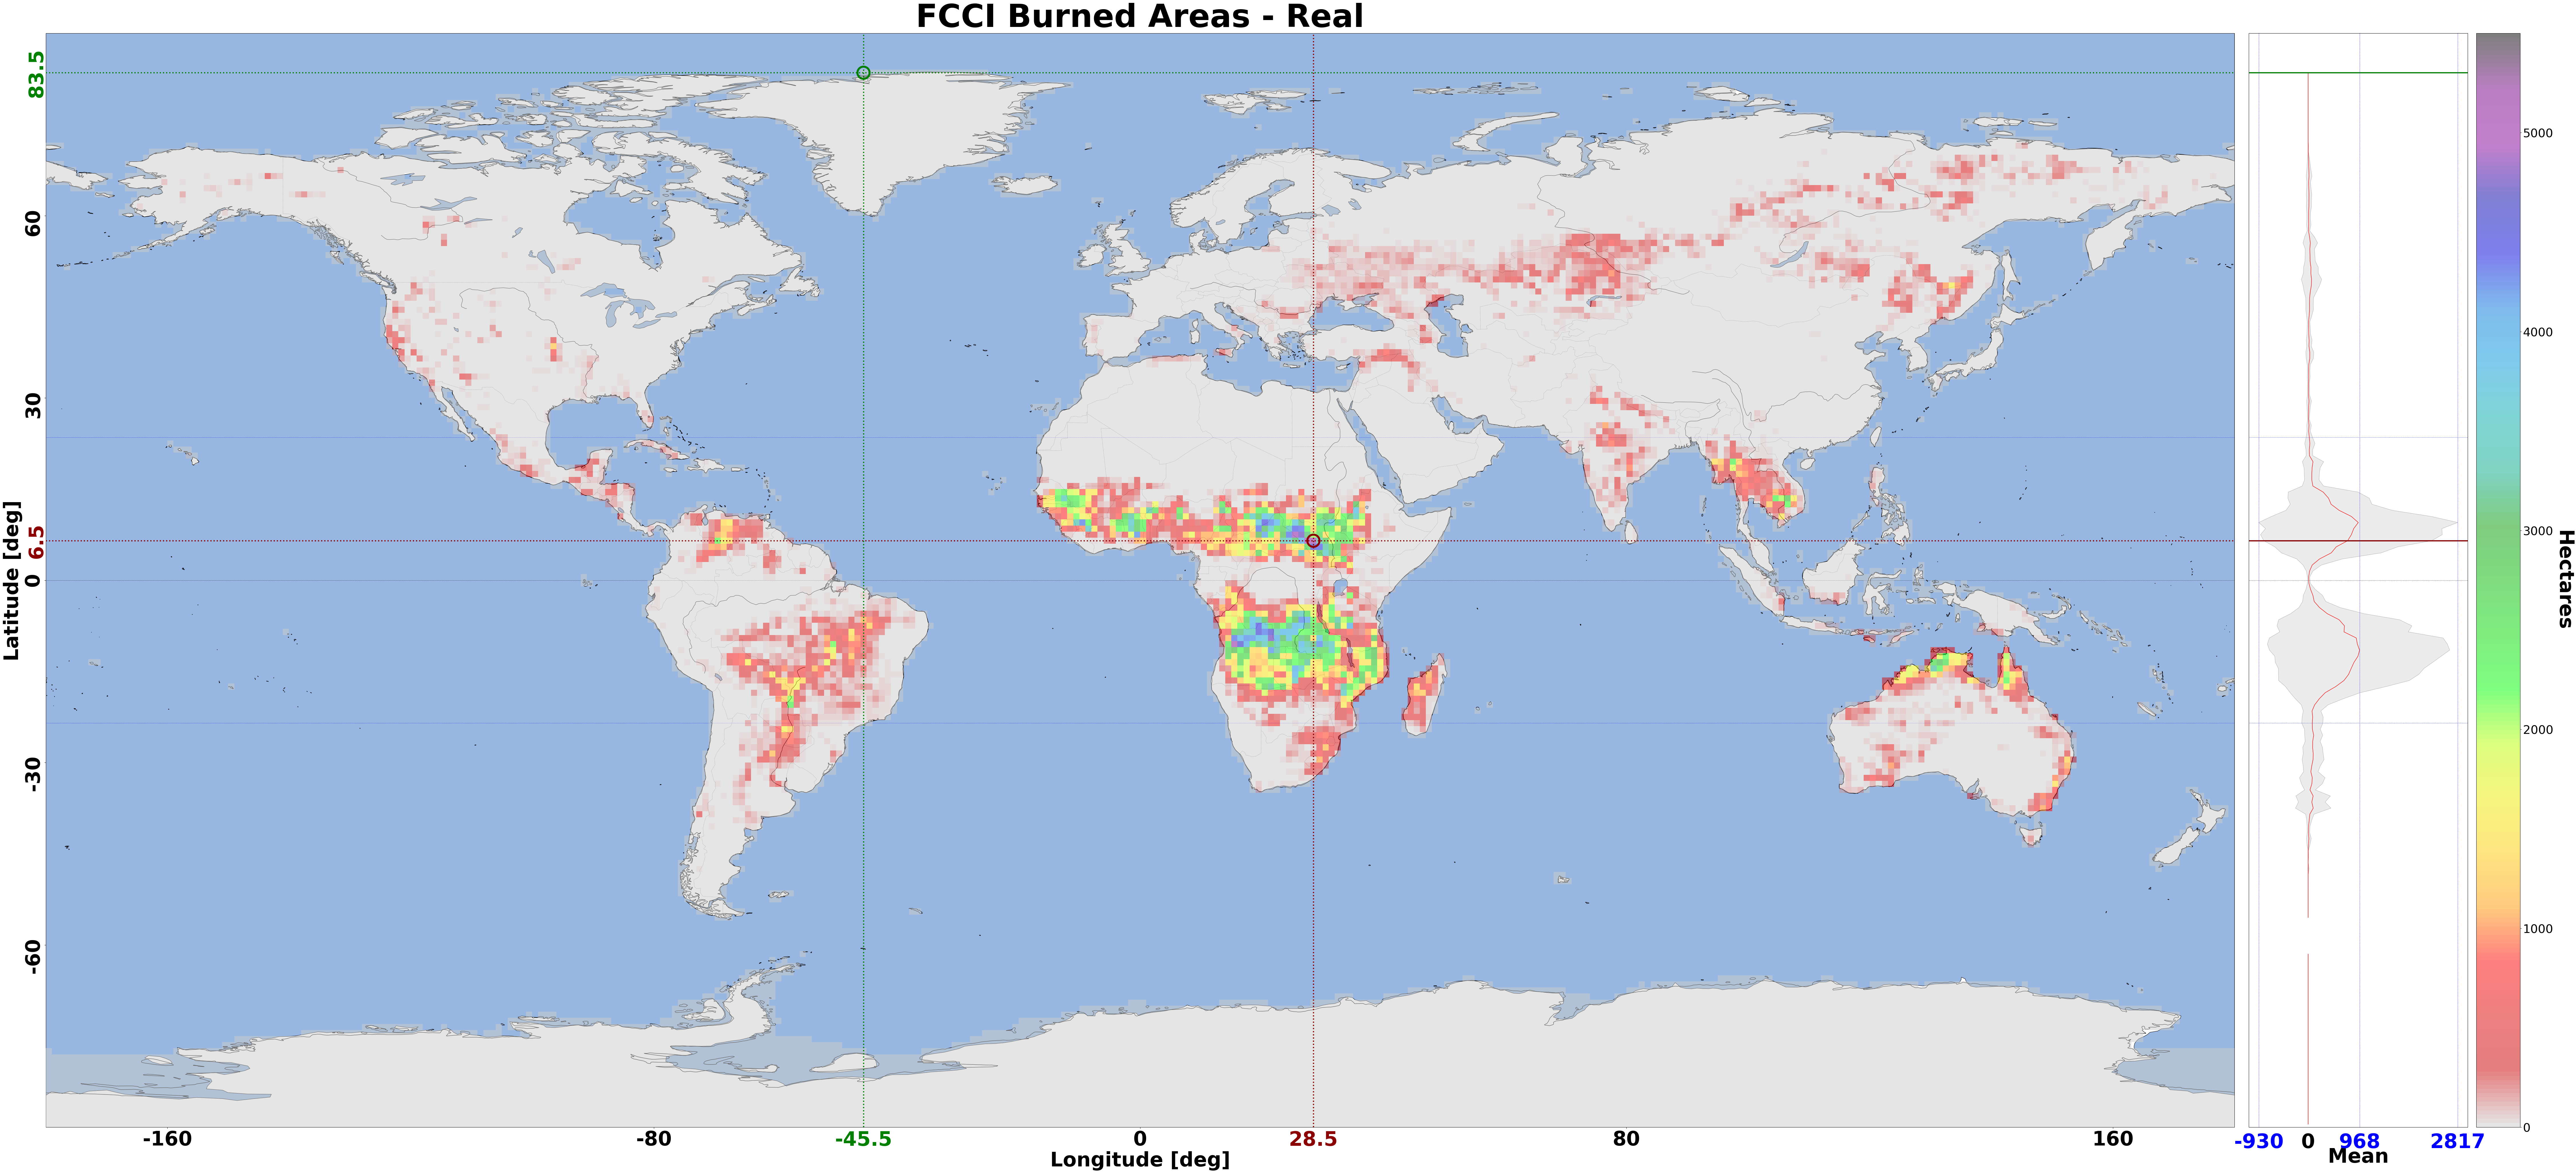

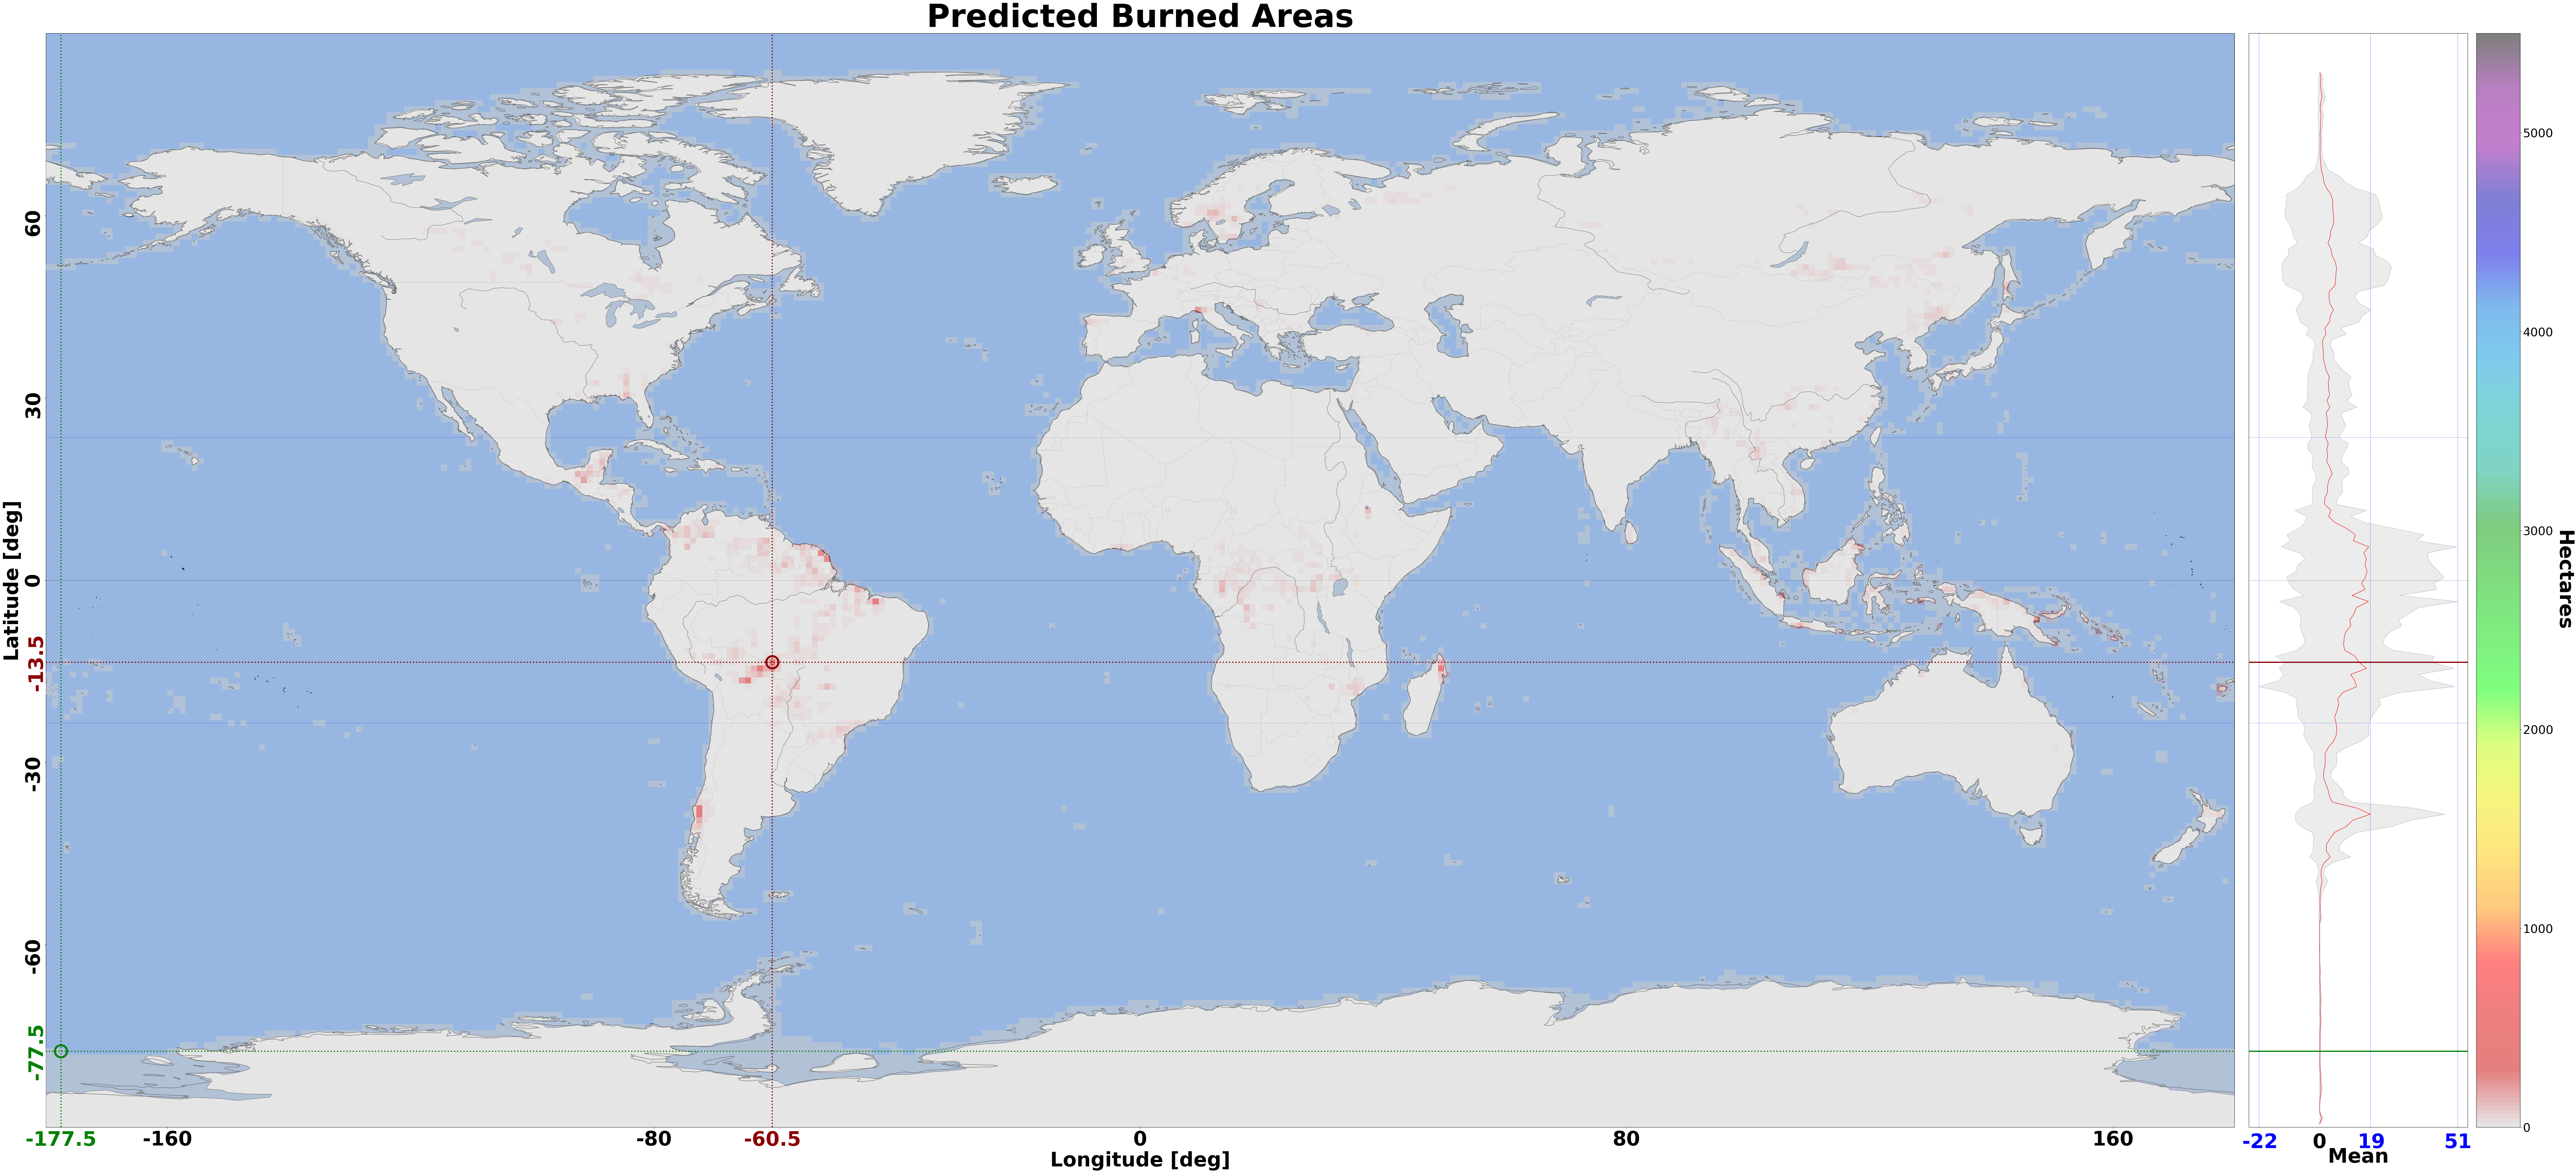

In [24]:
# real target data (temporal mean)
avg_real_on_time = test_data.fcci_ba.mean(dim='time', skipna=True).data
avg_real_descaled, avg_real_on_lats, avg_real_on_lons = compute_aggregated_data(data=avg_real_on_time)

# real target data (temporal standard deviation)
std_real_on_time = test_data.fcci_ba.std(dim='time', skipna=True).data
std_real_descaled, std_real_on_lats, std_real_on_lons = compute_aggregated_data(data=std_real_on_time)

# define upperbound and lowerbound data for plotting the average on latitudes
real_upperbound = avg_real_on_lats + std_real_on_lats
real_lowerbound = avg_real_on_lats - std_real_on_lats

plot_dataset_map(
	avg_target_data=avg_real_descaled,
	avg_data_on_lats=avg_real_on_lats,
	lowerbound_data=real_lowerbound,
	upperbound_data=real_upperbound,
	lats=lats,
	lons=lons,
	title = f'FCCI Burned Areas - Real',
	cmap = 'nipy_spectral_r'
)

# compute temporal mean for prediciton
avg_preds_on_time = np.nanmean(preds_array, axis=0)[0, ...]
avg_preds_descaled, avg_preds_on_lats, avg_preds_on_lons = compute_aggregated_data(data=avg_preds_on_time)

# compute temporal standard deviation for prediction
std_preds_on_time = np.nanstd(preds_array, axis=0)[0, ...]
std_preds_descaled, std_preds_on_lats, std_preds_on_lons = compute_aggregated_data(data=std_preds_on_time)

# define upperbound and lowerbound data for plotting the average on latitudes
preds_upperbound = avg_preds_on_lats + std_preds_on_lats
preds_lowerbound = avg_preds_on_lats - std_preds_on_lats

plot_dataset_map(
	avg_target_data=avg_preds_descaled,
	avg_data_on_lats=avg_preds_on_lats,
	lowerbound_data=preds_lowerbound,
	upperbound_data=preds_upperbound,
	lats=lats,
	lons=lons,
	title = f'Predicted Burned Areas',
	cmap = 'nipy_spectral_r'
)

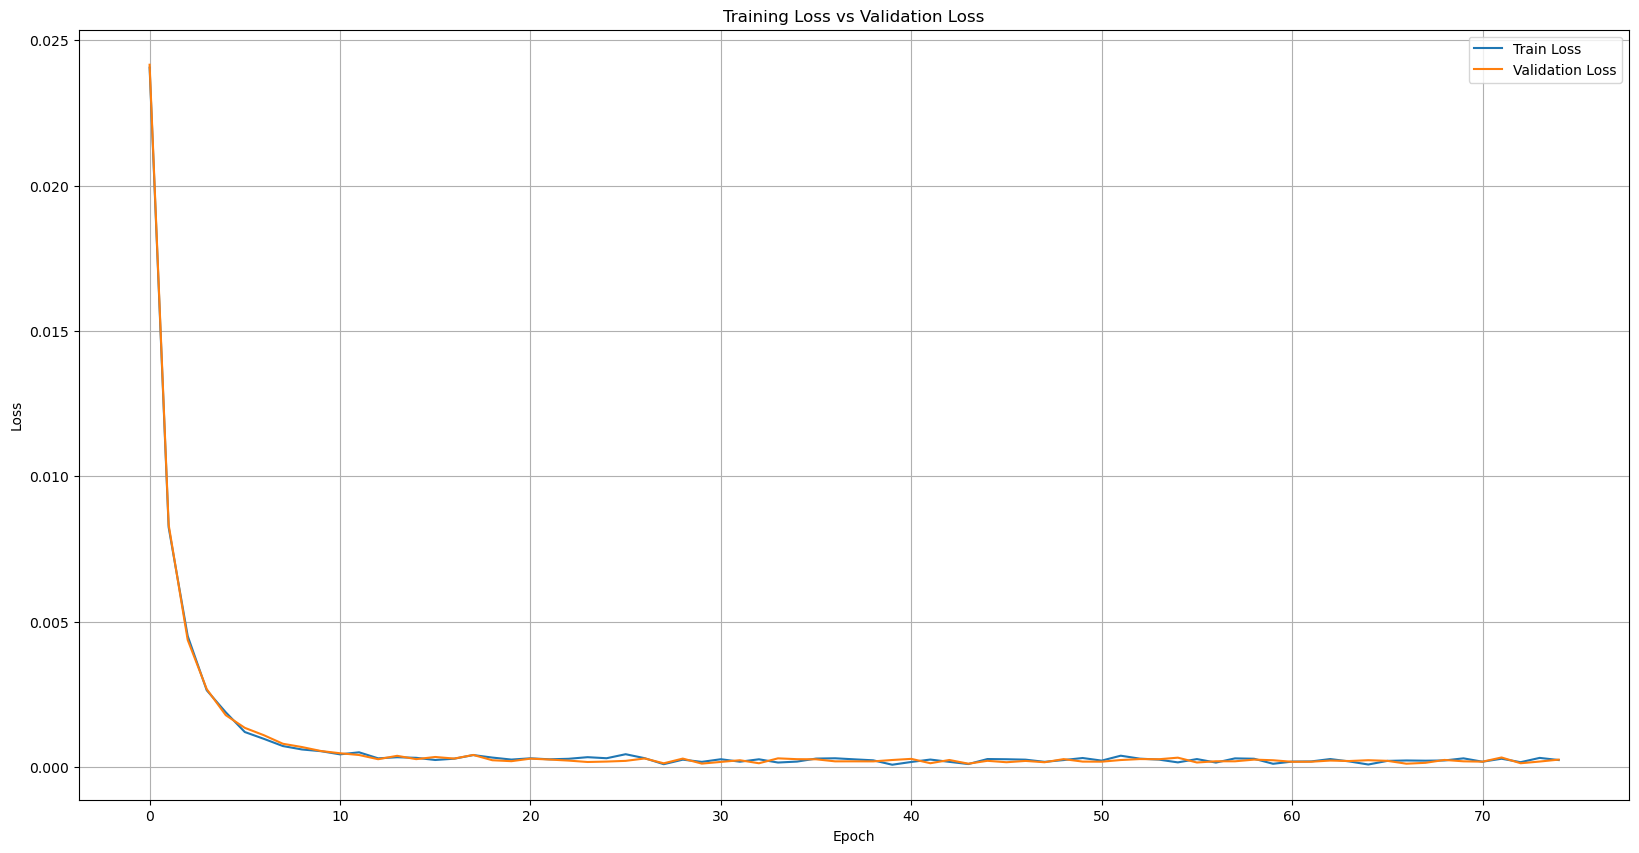

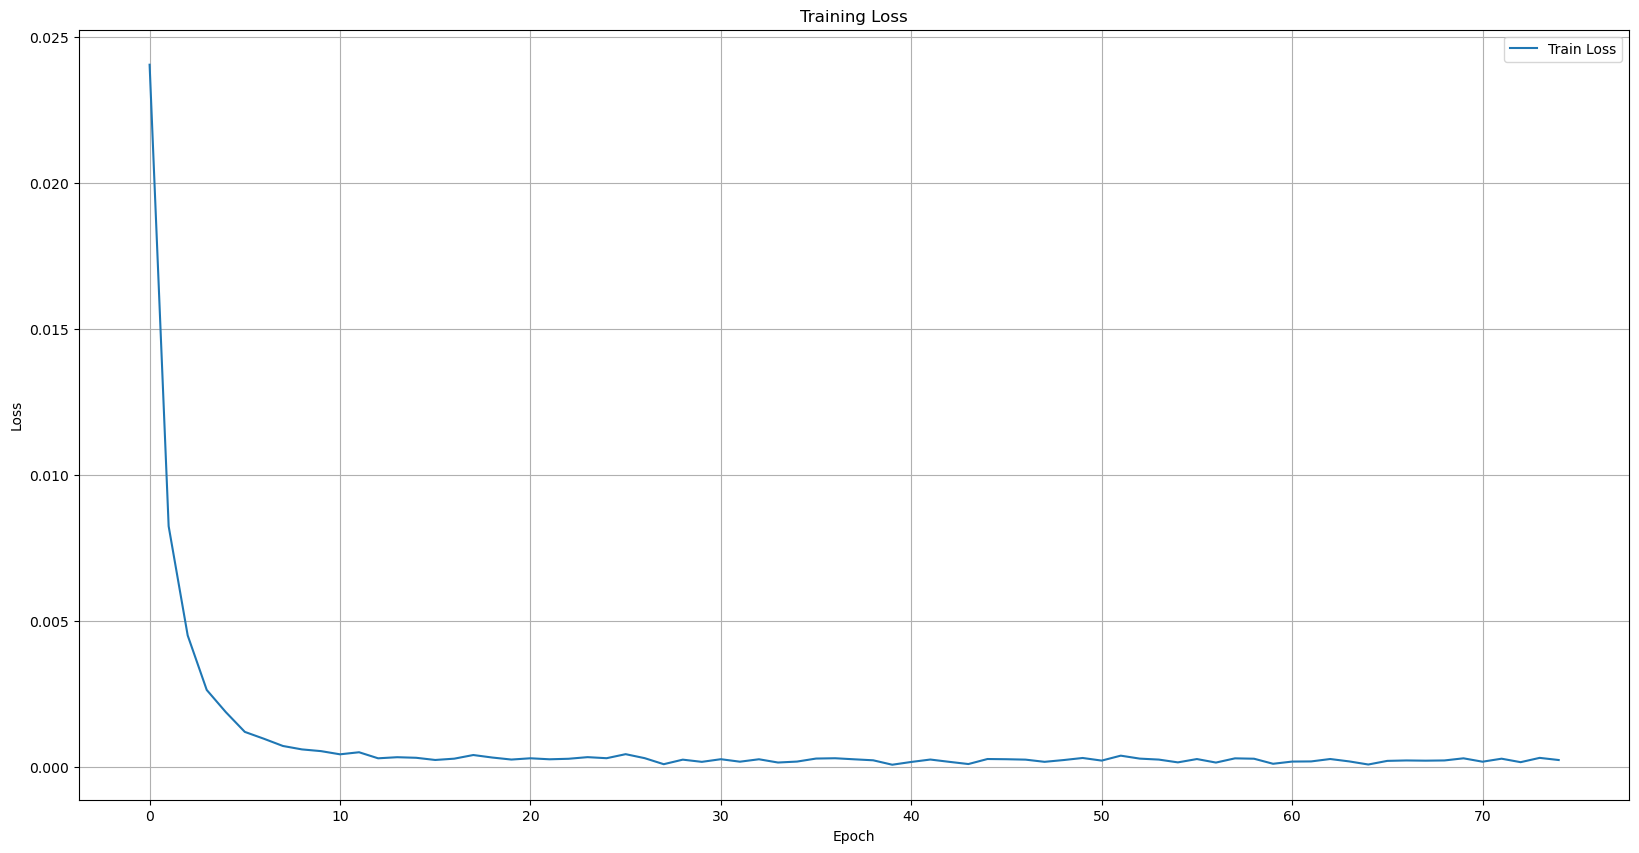

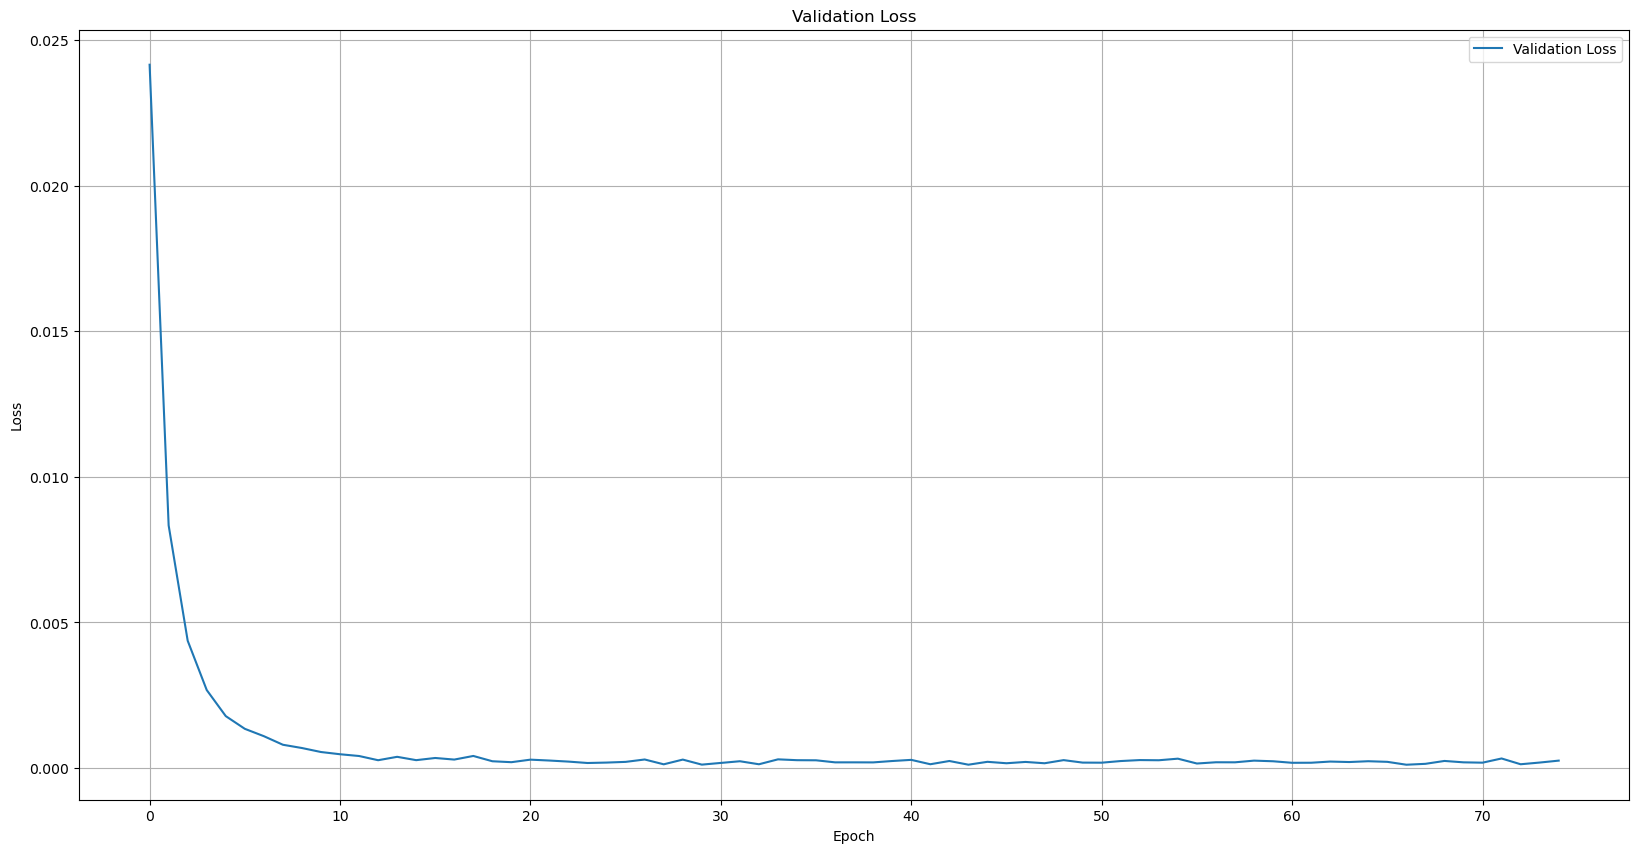

In [25]:
import pandas as pd

data = pd.read_csv("../experiments/20240717_256/fabric_benchmark.csv")

epochs = data['Unnamed: 0']
trn_loss = data['train_loss']
val_loss = data['val_loss']

plt.figure(figsize=(20, 10))
plt.plot(epochs, trn_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(epochs, trn_loss, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()